### Import

In [1]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna
import matplotlib.pyplot as plt
import datetime

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [3]:
dtypes = {
    'defaultPaymentMethod': str,
    'mode': str,
    'serviceClassificationName': str,
    'state': str,
    'address_county': str,
    'address_district': str,
    'discount_type': str,
    'subtotal': float,
    'travelingExpense': float,
    'discountNum': float,
    'isServicePackageBooking': float
}

In [4]:

df_main = pd.read_csv(
    r'C:\Users\USER\OneDrive\Documents\DSC_Project\20250517_資料集\一般訂單\main.csv',
    dtype=dtypes,
    low_memory=False
)

### Feature Engineering

In [5]:
# Feature Engineering: days_until_next_order
df_date_only = pd.to_datetime(df_main['createdAt']).dt.date
df_main['only_date'] = df_date_only
df_main = df_main.sort_values(['user_oid', 'only_date']).reset_index(level=0, drop=True)
df_main['only_date'] = pd.to_datetime(df_main['only_date'])
df_main['next_order_date'] = df_main.groupby('user_oid')['only_date'].shift(-1)
df_main['next_order_date'] = pd.to_datetime(df_main['next_order_date'])
df_main['days_until_next_order'] = (df_main['next_order_date'] - df_main['only_date']).dt.days

In [6]:
#Drop data after the cut-off point.

df_date_only = pd.to_datetime(df_date_only, errors="raise")

# Find the latest date in the 'createdAt' column
latest_date = df_date_only.max()

# Calculate the date 360 days before the latest date
cut_off_date = latest_date - pd.Timedelta(days=365)

# Drop rows where 'createdAt' is before the cut-off date
df_main = df_main[df_date_only <= cut_off_date]

print(f"DataFrame shape after dropping rows: {df_main.shape}")

DataFrame shape after dropping rows: (17427, 88)


In [7]:
# Feature Engineering: orders_last_365d
df_tmp = pd.DataFrame(df_main.groupby("user_oid").rolling("360D", on='only_date')['only_date'].count().shift(1).fillna(0).reset_index(level=0, drop=True))
df_tmp.columns = ['orders_last_365d']
df_tmp.reset_index(inplace=True)
df_main['orders_last_365d'] = df_tmp['orders_last_365d']

In [8]:
df_main["prev_mode"] = df_main.groupby("user_oid")["mode"].shift(1)
# df_main['first_order'] = df_main['prev_mode'].apply(lambda x: 1 if pd.isna(x) else 0)
df_main["prev_mode"] = df_main["prev_mode"].fillna('general') # Fill NaN values with 'general' for the first order

In [9]:
df_main['same_mode_as_last'] = (df_main['mode'] == df_main['prev_mode'])

### Data Preparation

In [10]:
num_cols = ['subtotal', 'discountNum'] #,'orders_last_365d'
cat_cols = ['defaultPaymentMethod', 'serviceClassificationName', 'state','address_county'  
            ,'same_mode_as_last','isServicePackageBooking',"prev_mode"]
X = df_main[num_cols + cat_cols].copy()
y = df_main['days_until_next_order'].apply(lambda x: 0 if pd.isna(x) or x > 365 else 1)
groups = df_main["user_oid"]

for col in cat_cols:
    X[col] = X[col].astype(str)

### Pipeline

In [11]:
# Preprocessing Pipeline
prep = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ],
    remainder='drop'
)

# Train-Test Split
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Optuna Objective Function for LightGBM
def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'random_state': 42,
        'class_weight': 'balanced'
    }
    
    lgbm = LGBMClassifier(**params)
    pipeline = Pipeline([('prep', prep), ('model', lgbm)])
    
    gss_cv = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    auc_scores = []
    
    for train_inner_idx, val_idx in gss_cv.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx]):
        X_train_inner = X.iloc[train_idx].iloc[train_inner_idx]
        y_train_inner = y.iloc[train_idx].iloc[train_inner_idx]
        X_val = X.iloc[train_idx].iloc[val_idx]
        y_val = y.iloc[train_idx].iloc[val_idx]
        
        pipeline.fit(X_train_inner, y_train_inner)
        val_preds = pipeline.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, val_preds))
    
    return np.mean(auc_scores)

# Optuna Objective Function for CatBoost
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'random_seed': 42,
        'auto_class_weights': 'Balanced',
        'verbose': 0
    }
    
    catboost = CatBoostClassifier(**params)
    pipeline = Pipeline([('prep', prep), ('model', catboost)])
    
    gss_cv = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    auc_scores = []
    
    for train_inner_idx, val_idx in gss_cv.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx]):
        X_train_inner = X.iloc[train_idx].iloc[train_inner_idx]
        y_train_inner = y.iloc[train_idx].iloc[train_inner_idx]
        X_val = X.iloc[train_idx].iloc[val_idx]
        y_val = y.iloc[train_idx].iloc[val_idx]
        
        pipeline.fit(X_train_inner, y_train_inner)
        val_preds = pipeline.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, val_preds))
    
    return np.mean(auc_scores)

# Run Optuna Optimization
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=20)
print("Best LightGBM Parameters:", study_lgbm.best_params)
print("Best LightGBM AUC:", study_lgbm.best_value)

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=20)
print("Best CatBoost Parameters:", study_catboost.best_params)
print("Best CatBoost AUC:", study_catboost.best_value)

# Base Learners with Optimized Parameters
lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=study_lgbm.best_params['n_estimators'],
    learning_rate=study_lgbm.best_params['learning_rate'],
    num_leaves=study_lgbm.best_params['num_leaves'],
    random_state=42,
    class_weight='balanced'
)

catboost = CatBoostClassifier(
    iterations=study_catboost.best_params['iterations'],
    learning_rate=study_catboost.best_params['learning_rate'],
    depth=study_catboost.best_params['depth'],
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=0
)

# Stacking: Generate out-of-fold predictions for training set
gss_inner = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
lgbm_oof_preds = np.zeros(len(train_idx))
catboost_oof_preds = np.zeros(len(train_idx))
smote = SMOTE(random_state=42)

for fold, (train_inner_idx, val_idx) in enumerate(gss_inner.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx])):
    # Preprocess training and validation data
    X_train_inner = X.iloc[train_idx].iloc[train_inner_idx]
    y_train_inner = y.iloc[train_idx].iloc[train_inner_idx]
    X_val = X.iloc[train_idx].iloc[val_idx]
    
    # Fit preprocessor
    X_train_inner_prepped = prep.fit_transform(X_train_inner)
    X_val_prepped = prep.transform(X_val)
    
    # Apply SMOTE to preprocessed training data
    X_train_inner_smote, y_train_inner_smote = smote.fit_resample(X_train_inner_prepped, y_train_inner)
    
    # Train LGBM
    lgbm.fit(X_train_inner_smote, y_train_inner_smote)
    lgbm_oof_preds[val_idx] = lgbm.predict_proba(X_val_prepped)[:, 1]
    
    # Train CatBoost
    catboost.fit(X_train_inner_smote, y_train_inner_smote)
    catboost_oof_preds[val_idx] = catboost.predict_proba(X_val_prepped)[:, 1]

# Train base models on full training data with SMOTE
X_train_prepped = prep.fit_transform(X.iloc[train_idx])
X_test_prepped = prep.transform(X.iloc[test_idx])
X_train_smote, y_train_smote = smote.fit_resample(X_train_prepped, y.iloc[train_idx])

lgbm.fit(X_train_smote, y_train_smote)
lgbm_test_preds = lgbm.predict_proba(X_test_prepped)[:, 1]

catboost.fit(X_train_smote, y_train_smote)
catboost_test_preds = catboost.predict_proba(X_test_prepped)[:, 1]

# Prepare meta-features
meta_train = np.column_stack((lgbm_oof_preds, catboost_oof_preds))
meta_test = np.column_stack((lgbm_test_preds, catboost_test_preds))

# Train Meta-Learner (Logistic Regression)
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(meta_train, y.iloc[train_idx])

[I 2025-06-12 16:26:07,680] A new study created in memory with name: no-name-5318d2cd-76bc-4825-8945-2aebfabd4041


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:10,256] Trial 0 finished with value: 0.7225244844769639 and parameters: {'n_estimators': 211, 'learning_rate': 0.02175476327197756, 'num_leaves': 36}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:12,248] Trial 1 finished with value: 0.7118365601560139 and parameters: {'n_estimators': 464, 'learning_rate': 0.023663297135268515, 'num_leaves': 55}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:14,248] Trial 2 finished with value: 0.6887470094450262 and parameters: {'n_estimators': 453, 'learning_rate': 0.08977490813142734, 'num_leaves': 64}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:15,267] Trial 3 finished with value: 0.7205385054132806 and parameters: {'n_estimators': 207, 'learning_rate': 0.023125299052669385, 'num_leaves': 50}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:18,690] Trial 4 finished with value: 0.6802416055042082 and parameters: {'n_estimators': 490, 'learning_rate': 0.08253334671744442, 'num_leaves': 107}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:20,442] Trial 5 finished with value: 0.7136378710131819 and parameters: {'n_estimators': 228, 'learning_rate': 0.018376189921496085, 'num_leaves': 98}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:22,232] Trial 6 finished with value: 0.705577849370017 and parameters: {'n_estimators': 448, 'learning_rate': 0.03809789393636457, 'num_leaves': 53}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:23,955] Trial 7 finished with value: 0.7125203230583216 and parameters: {'n_estimators': 387, 'learning_rate': 0.02482343318036174, 'num_leaves': 58}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:25,041] Trial 8 finished with value: 0.7194563900652621 and parameters: {'n_estimators': 281, 'learning_rate': 0.029949818179272548, 'num_leaves': 37}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:25,790] Trial 9 finished with value: 0.7189284015811129 and parameters: {'n_estimators': 107, 'learning_rate': 0.013046832280863101, 'num_leaves': 71}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:26,952] Trial 10 finished with value: 0.7045815639396776 and parameters: {'n_estimators': 119, 'learning_rate': 0.0564809309431895, 'num_leaves': 127}. Best is trial 0 with value: 0.7225244844769639.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:27,807] Trial 11 finished with value: 0.7238726124764207 and parameters: {'n_estimators': 200, 'learning_rate': 0.010737261783464336, 'num_leaves': 33}. Best is trial 11 with value: 0.7238726124764207.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:28,572] Trial 12 finished with value: 0.7243188476063901 and parameters: {'n_estimators': 189, 'learning_rate': 0.010198346252298447, 'num_leaves': 31}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:29,255] Trial 13 finished with value: 0.723810642422143 and parameters: {'n_estimators': 162, 'learning_rate': 0.01080434576324675, 'num_leaves': 31}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binar

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:31,164] Trial 14 finished with value: 0.7148215971722166 and parameters: {'n_estimators': 301, 'learning_rate': 0.014312609686996842, 'num_leaves': 87}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:32,381] Trial 15 finished with value: 0.7236785310157652 and parameters: {'n_estimators': 289, 'learning_rate': 0.010031334457226692, 'num_leaves': 43}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:33,615] Trial 16 finished with value: 0.7192445163376219 and parameters: {'n_estimators': 168, 'learning_rate': 0.015726909098351075, 'num_leaves': 79}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:34,878] Trial 17 finished with value: 0.7107619754046709 and parameters: {'n_estimators': 336, 'learning_rate': 0.0437670289691406, 'num_leaves': 44}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:35,599] Trial 18 finished with value: 0.7241272706832772 and parameters: {'n_estimators': 164, 'learning_rate': 0.011742585049747511, 'num_leaves': 31}. Best is trial 12 with value: 0.7243188476063901.


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 57
[LightGBM] [Info] [binar

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 16:26:36,487] Trial 19 finished with value: 0.7210453131901572 and parameters: {'n_estimators': 148, 'learning_rate': 0.016361892560844107, 'num_leaves': 63}. Best is trial 12 with value: 0.7243188476063901.
[I 2025-06-12 16:26:36,492] A new study created in memory with name: no-name-e58710ab-421f-4916-952c-cccc3bb51423


Best LightGBM Parameters: {'n_estimators': 189, 'learning_rate': 0.010198346252298447, 'num_leaves': 31}
Best LightGBM AUC: 0.7243188476063901


[I 2025-06-12 16:26:46,772] Trial 0 finished with value: 0.7226532754522949 and parameters: {'iterations': 458, 'learning_rate': 0.041630566888207966, 'depth': 6}. Best is trial 0 with value: 0.7226532754522949.
[I 2025-06-12 16:26:53,133] Trial 1 finished with value: 0.7236029526301705 and parameters: {'iterations': 269, 'learning_rate': 0.02564681105962283, 'depth': 6}. Best is trial 1 with value: 0.7236029526301705.
[I 2025-06-12 16:27:05,399] Trial 2 finished with value: 0.7214705598373709 and parameters: {'iterations': 174, 'learning_rate': 0.04463159805231325, 'depth': 10}. Best is trial 1 with value: 0.7236029526301705.
[I 2025-06-12 16:27:20,335] Trial 3 finished with value: 0.7245179516615868 and parameters: {'iterations': 470, 'learning_rate': 0.015277799107542199, 'depth': 8}. Best is trial 3 with value: 0.7245179516615868.
[I 2025-06-12 16:27:41,299] Trial 4 finished with value: 0.7142495601116381 and parameters: {'iterations': 277, 'learning_rate': 0.06251270790882327, 'de

Best CatBoost Parameters: {'iterations': 241, 'learning_rate': 0.0584295762921038, 'depth': 5}
Best CatBoost AUC: 0.7266369022470447
[LightGBM] [Info] Number of positive: 7341, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3664
[LightGBM] [Info] Number of data points in the train set: 14682, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7345, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3660
[LightGBM] [Info] Number of data points in the train set: 14690, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7328, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3873
[LightGBM] [Info] Number of data points in the train set: 14656, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7342, number of negative: 7342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3915
[LightGBM] [Info] Number of data points in the train set: 14684, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7341, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3913
[LightGBM] [Info] Number of data points in the train set: 14682, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9176, number of negative: 9176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4109
[LightGBM] [Info] Number of data points in the train set: 18352, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LogisticRegression(random_state=42)

### Prediction

In [12]:
# Final Predictions
pred_proba = meta_learner.predict_proba(meta_test)[:, 1]

### Threshold Adjustment

In [13]:
# Find Optimal Threshold (Youden's J statistic)
fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], pred_proba)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Adjust predictions based on the optimal threshold
pred_adjusted = (pred_proba >= optimal_threshold).astype(int)

Optimal Threshold (Youden's J): 0.4254


### Eval

In [14]:
# Evaluation
print(f"\nAccuracy (Adjusted Threshold): {accuracy_score(y.iloc[test_idx], pred_adjusted):.2f}")
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y.iloc[test_idx], pred_adjusted))


Accuracy (Adjusted Threshold): 0.69

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2322
           1       0.54      0.50      0.52      1166

    accuracy                           0.69      3488
   macro avg       0.65      0.64      0.64      3488
weighted avg       0.68      0.69      0.69      3488



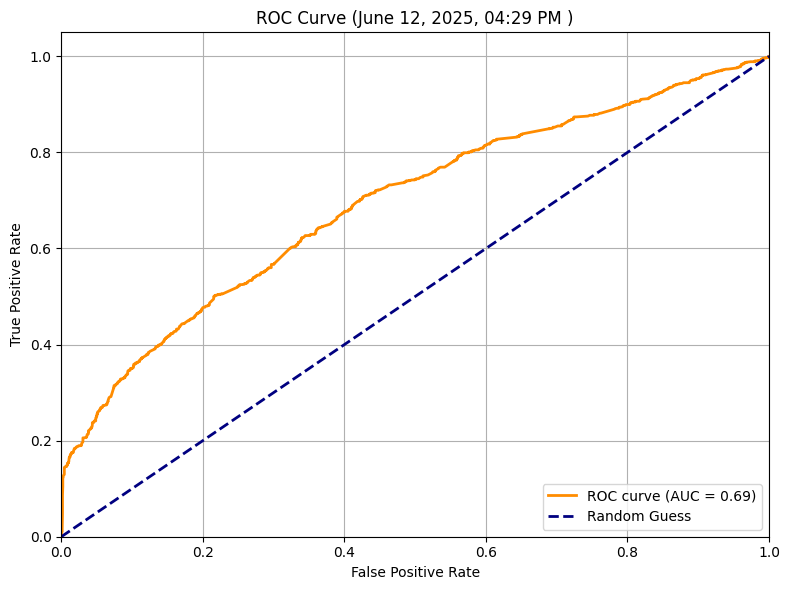

In [15]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y.iloc[test_idx], pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# G-Mean
cm_adjusted = confusion_matrix(y.iloc[test_idx], pred_adjusted)
recall_0 = cm_adjusted[0, 0] / (cm_adjusted[0, 0] + cm_adjusted[0, 1])
recall_1 = cm_adjusted[1, 1] / (cm_adjusted[1, 0] + cm_adjusted[1, 1])
gmean = np.sqrt(recall_0 * recall_1)
print(f"\nG-Mean (Adjusted Threshold): {gmean:.4f}")
print(f"Recall Class 0 (Specificity): {recall_0:.4f}")
print(f"Recall Class 1 (Sensitivity): {recall_1:.4f}")


G-Mean (Adjusted Threshold): 0.6269
Recall Class 0 (Specificity): 0.7834
Recall Class 1 (Sensitivity): 0.5017



Confusion Matrix (Adjusted Threshold):
[[1819  503]
 [ 581  585]]


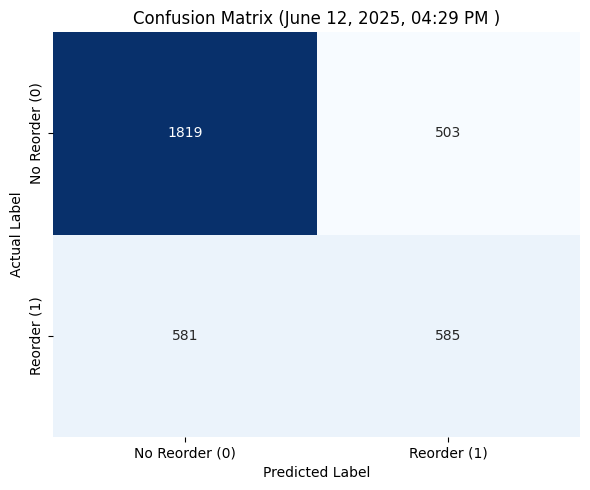

In [17]:
# Confusion Matrix
print("\nConfusion Matrix (Adjusted Threshold):")
print(cm_adjusted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Reorder (0)', 'Reorder (1)'],
            yticklabels=['No Reorder (0)', 'Reorder (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
plt.tight_layout()
plt.show()